In [1]:
# 第一步：安装必要的库并执行授权
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# 第二步：挂载Google Drive
!mkdir -p drive
!google-drive-ocamlfuse drive
# # 第三步：更改工作目录
# import os
# os.chdir("drive/app")#drive/为网盘根目录，后面的可以自己设定

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("drive/DSR/src")#drive/为网盘根目录，后面的可以自己设定

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar  4 09:20:22 2018

@author: gyhu
"""
#%%
import numpy as np
import keras
import GetDataUtil

#%%
'''1. Get the train and test dataset.'''
# 数据增强后
X_train_origin, X_test_origin, y_train, y_test = GetDataUtil.getTrainTestSet(dataPath = "../DataSet_NPSave/RandomCrop_NPAWF_Noise_orgin_all_ACC_005_10000.npy",test_size = 0.1)

# 数据增强前
#X_train_origin, X_test_origin, y_train, y_test = GetDataUtil.getTrainTestSet(dataPath = "../DataSet_NPSave/JustifiedData.npy",test_size = 0.1)

#%%
'''2. Data preprocessing'''
def DataPreprocess(data):
    print("Data Preprocessing,Please wait...")
    '''
    # 加速度归一化 0~1
    
    data[:,:3,:] /= 16
    data[:,:3,:] *= 32768.0
    data[:,:3,:] += 32768.0
    data[:,:3,:] /= 65535.0
    
    # 角速度归一化 0~1
    data[:,3:6,:] /= 2000
    data[:,3:6,:] *= 32768.0
    data[:,3:6,:] += 32768.0
    data[:,3:6,:] /= 65535.0
    '''
    data[:,:3,:] = (data[:,:3,:] - np.mean(data[:,:3,:]))/np.std(data[:,:3,:])
    data[:,3:6,:] = (data[:,3:6,:] - np.mean(data[:,3:6,:]))/np.std(data[:,3:6,:])
    
    # 特征构造
    sin = np.sin(data * np.pi / 2)
    cos = np.cos(data * np.pi / 2)
    X_2 = np.power(data,2)
    X_3 = np.power(data,3)   
    ACC_All = np.sqrt((np.power(data[:,0,:],2)+
                      np.power(data[:,1,:],2)+
                      np.power(data[:,2,:],2))/3)[:,np.newaxis,:]    
    Ay_Gz = (data[:,1,:] * data[:,5,:])[:,np.newaxis,:]
    Ay_2_Gz = (np.power(data[:,1,:],2) * data[:,5,:])[:,np.newaxis,:]
    Ay_Gz_2 = (np.power(data[:,5,:],2) * data[:,1,:])[:,np.newaxis,:]
    Ax_Gy = (data[:,0,:] * data[:,4,:])[:,np.newaxis,:]
    Ax_2_Gy = (np.power(data[:,0,:],2) * data[:,4,:])[:,np.newaxis,:]
    Ax_Gy_2 = (np.power(data[:,4,:],2) * data[:,0,:])[:,np.newaxis,:]
    
    Ax_Ay_Az = (data[:,0,:]*data[:,1,:]*data[:,2,:])[:,np.newaxis,:]
    
    newData = np.concatenate((data,sin,cos,X_3,X_2,ACC_All,Ay_Gz,Ay_2_Gz,Ay_Gz_2,Ax_Gy,
                           Ax_2_Gy,Ax_Gy_2,Ax_Ay_Az),axis = 1)
    
    # data *= 255
    print(np.min(data))
    print(np.max(data))
    
    print("Finished!")
    return newData

X_train = DataPreprocess(X_train_origin)
X_test = DataPreprocess(X_test_origin)

# 测试用，不做数据预处理    
# X_train = X_train_origin
# X_test = X_test_origin
#%%
'''3. 将标签转换为one_hot稀疏值'''
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train-1,5)
y_test = np_utils.to_categorical(y_test-1,5)

#%%
'''卷积神经网络input需要dim = 4'''
X_train = X_train[:,np.newaxis,:,:]
X_test = X_test[:,np.newaxis,:,:]
# (9000, 1, 38, 300)
print(X_train.shape)

#%%
'''4. 神经网络模型 Labels = ["加速","碰撞","匀速","左转","右转"]'''
import time
import sklearn
from keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Dense
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras.layers.core import Activation,Flatten
from keras.layers.pooling import MaxPooling2D,AveragePooling2D
from keras.layers.core import Dropout
# 
inputs = Input(shape = (1,X_train.shape[2],300),name="Input")

x = Conv2D(filters = 128,
           kernel_size = (2,2),#尝试方形kernel 纵向也可能相关
           strides = (1,1),
           padding = 'same',
           use_bias = True,# 尝试加一下bias
           kernel_initializer = TruncatedNormal(stddev=0.0001),
           kernel_regularizer = regularizers.l2(0.1),
           name = "Conv1")(inputs)
#x = BatchNormalization(axis = 1,name = "BN1")(x)# 尝试去掉BN
x = Activation('tanh',name = 'relu1')(x)
x = MaxPooling2D(pool_size = (3,3),strides = (1,1),padding = 'same')(x)
# x = Dropout(0.1)(x)#0.1zuoyou
x = Conv2D(filters = 64,
           kernel_size = (3,3),
           strides = (1,1),
           padding = 'same',
           use_bias = True,
           kernel_initializer = TruncatedNormal(stddev=0.001),
           kernel_regularizer = regularizers.l2(0.1),
           name = "Conv2")(x)
# x = BatchNormalization(axis = 1,name = 'BN2')(x)
x = Activation('tanh',name = 'relu2')(x)
x = MaxPooling2D(pool_size = (3,3),strides = (1,1),padding = 'same')(x)
#x = Dropout(0.1)(x)
#
#x = Conv2D(filters = 128,
#           kernel_size = (1,5),
#           strides = (1,3),
#           padding = 'same',
#           use_bias = False,
#           kernel_initializer = TruncatedNormal(stddev=0.001),
#           kernel_regularizer = regularizers.l2(0.01),
#           name = "Conv3")(x)
#x = BatchNormalization(axis = 1,name = "BN3")(x)
#x = Activation('relu',name = 'relu3')(x)
#x = MaxPooling2D(pool_size = (1,3),strides = (1,2),padding = 'same')(x)
#x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(1024,
          kernel_initializer = TruncatedNormal(stddev=0.01),
          kernel_regularizer = regularizers.l2(0.01),
#          activation='relu',
          name = "D1")(x)
# x = BatchNormalization(axis = 1,name="D1_BN")(x)
x = Activation('tanh',name = 'D1_relu')(x)
# x = Dropout(0.1)(x)

x = Dense(512,
#          activation='relu',
          kernel_initializer = TruncatedNormal(stddev=0.01),
          kernel_regularizer = regularizers.l2(0.01),
          name="D2")(x)
# x = BatchNormalization(axis = 1,name="D2_BN")(x)
x = Activation('tanh',name = 'D2_relu')(x)

x = Dense(256,
          activation='relu',
          kernel_initializer = TruncatedNormal(stddev=0.1),
          kernel_regularizer = regularizers.l2(0.01),
          name="D3")(x)

# x = BatchNormalization(axis = 1,name="D3_BN")(x)
x = Activation('tanh',name = 'D3_relu')(x)

out = Dense(5,activation='softmax',name="OutPut")(x)

model = Model(inputs = inputs,outputs = out)
model.compile(optimizer = 'Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("正在训练网络，请耐心等候......")
#X_train,y_train = shuffle(X_train,y_train,random_state=None)

startTime = time.clock()
trainLog = model.fit(X_train,
          y_train,
          validation_split = 0.03,
          batch_size=512,
          epochs=10,
          verbose=1
          )
endTime = time.clock()
# 注意，这里的时间window和linux不同
print("网络训练已完成 耗时%f 秒"%((float)(endTime - startTime)/10))

# 绘制模型的结构图 此处还出现点问题，待解a决
# plot_model(model,
#            to_file='model.png',
#            show_shapes=True,
#            show_layer_names=True)

'''注意：sklearn中的标签都不是稀疏的'''
from sklearn.metrics import classification_report
predict = model.predict(X_test)
print("测试集预测结果：")
print(classification_report(np.argmax(y_test,axis = 1),np.argmax(predict,axis = 1)))
# 打印混淆矩阵
print("测试集混淆矩阵：")
print(sklearn.metrics.confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(predict,axis = 1)))

#%%
# from keras.models import load_model
# 保存模型
model.save('my_model.h5')

#%%
print(trainLog)
# plot_model(model,
#            to_file='model.png',
#            show_shapes=True,
#            show_layer_names=True)


Using TensorFlow backend.


Data Preprocessing,Please wait...
-23.879221323377323
25.546878984539767
Finished!
Data Preprocessing,Please wait...
-22.375611911690843
22.52441922717608
Finished!
(9000, 1, 38, 300)
正在训练网络，请耐心等候......
Train on 8730 samples, validate on 270 samples
Epoch 1/10
8730/8730 [==============================] - 4s 409us/step - loss: 10.8439 - acc: 0.6643 - val_loss: 8.5226 - val_acc: 0.7704
Epoch 2/10
8730/8730 [==============================] - 1s 147us/step - loss: 7.2236 - acc: 0.8749 - val_loss: 5.8872 - val_acc: 0.9037
Epoch 3/10
8730/8730 [==============================] - 1s 146us/step - loss: 5.1431 - acc: 0.9488 - val_loss: 4.1997 - val_acc: 0.9963
Epoch 4/10
8730/8730 [==============================] - 1s 148us/step - loss: 3.6449 - acc: 0.9934 - val_loss: 3.0108 - val_acc: 1.0000
Epoch 5/10
8730/8730 [==============================] - 1s 141us/step - loss: 2.6428 - acc: 0.9843 - val_loss: 2.2291 - val_acc: 0.9630
Epoch 6/10
8730/8730 [==============================] - 1s 140us/step

8730/8730 [==============================] - 1s 141us/step - loss: 1.3912 - acc: 0.9927 - val_loss: 1.2850 - val_acc: 0.8778
Epoch 8/10
8730/8730 [==============================] - 1s 139us/step - loss: 1.1470 - acc: 0.9371 - val_loss: 0.9583 - val_acc: 0.9926
Epoch 9/10
8730/8730 [==============================] - 1s 139us/step - loss: 0.8308 - acc: 0.9916 - val_loss: 0.6885 - val_acc: 0.9926
Epoch 10/10
8730/8730 [==============================] - 1s 138us/step - loss: 0.6118 - acc: 0.9944 - val_loss: 0.5968 - val_acc: 0.9556
网络训练已完成 耗时1.459000 秒
测试集预测结果：
             precision    recall  f1-score   support

          0       0.71      0.99      0.83       220
          1       1.00      0.99      0.99       191
          2       0.97      0.56      0.71       194
          3       1.00      0.99      1.00       187
          4       1.00      0.99      1.00       208

avg / total       0.93      0.91      0.90      1000

测试集混淆矩阵：
[[218   0   2   0   0]
 [  2 189   0   0   0]
 [ 85  

explained variance ratio (first two components): [0.61559906 0.0338008 ]


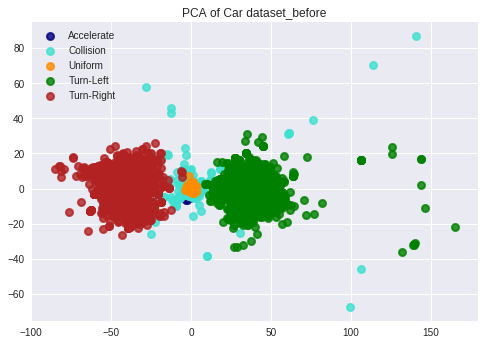

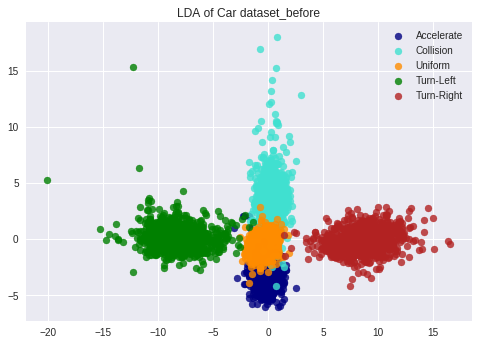

In [4]:
import matplotlib.pyplot as plt

# from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# iris = datasets.load_iris()

# print(iris.target_names)
# print(np.argmax(y_train,axis = 1))
# X_train_origin
X = X_train_origin.reshape(-1,6*300)
# X = DataPreprocess(X_train_origin).reshape(-1,38*300)
y = np.argmax(y_train,axis = 1)
target_names = ["Accelerate",'Collision',"Uniform","Turn-Left","Turn-Right"]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','green','firebrick']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2,3,4,5], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Car dataset_before')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2,3,4,5], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Car dataset_before')

plt.show()


explained variance ratio (first two components): [0.61559906 0.0338008  0.02902389]


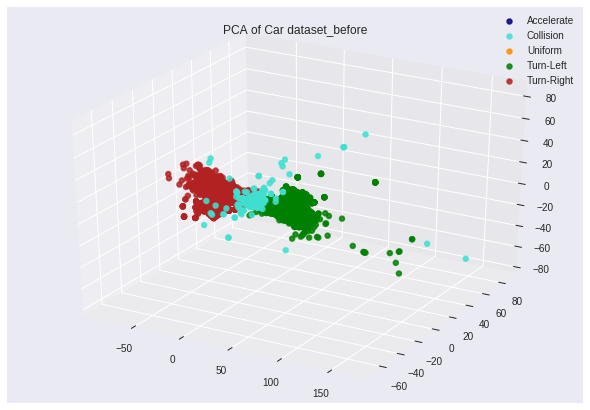

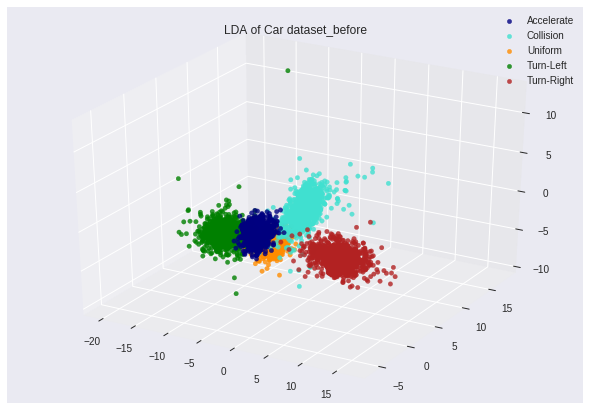

In [7]:
# 三维可视化
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = X_train_origin.reshape(-1,6*300)
# X = DataPreprocess(X_train_origin).reshape(-1,38*300)
y = np.argmax(y_train,axis = 1)
target_names = ["Accelerate",'Collision',"Uniform","Turn-Left","Turn-Right"]

pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=3)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
ax = Axes3D(fig)

colors = ['navy', 'turquoise', 'darkorange','green','firebrick']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2,3,4,5], target_names):
    ax.scatter(X_r[y == i, 0], X_r[y == i, 1], X_r[y==i,2],color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Car dataset_before')

fig = plt.figure()
ax = Axes3D(fig)
for color, i, target_name in zip(colors, [0, 1, 2,3,4,5], target_names):
    #plt.scatter(x, y, z, c=y3, marker='.', s=50, label='')
    ax.scatter(X_r2[y == i, 0], X_r2[y == i, 1],X_r2[y == i,2],alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Car dataset_before')

plt.show()

Data Preprocessing,Please wait...
-23.87922132337732
25.54687898453977
Finished!


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


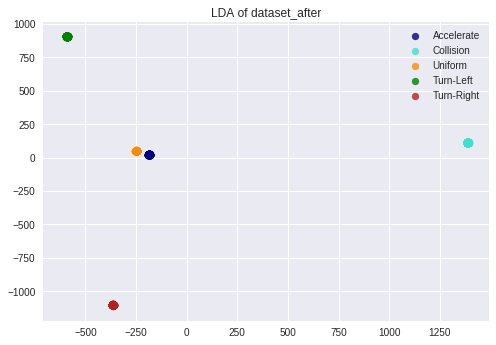

In [10]:
# print(X_r2[0])
# X_r2[y == 3, 1].shape
X = DataPreprocess(X_train_origin).reshape(-1,38*300)
y = np.argmax(y_train,axis = 1)
lda = LinearDiscriminantAnalysis(n_components=2)

X_r2 = lda.fit(X, y).transform(X)
plt.figure()
for color, i, target_name in zip(colors, [0,1,2,3,4], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of dataset_after')

plt.show()

Data Preprocessing,Please wait...
-23.879221323377323
25.54687898453977
Finished!


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


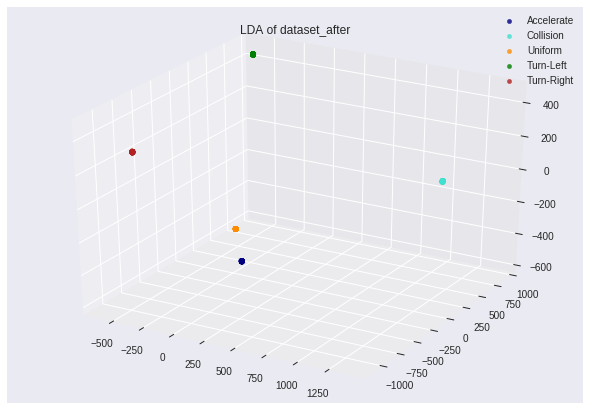

In [11]:
X = DataPreprocess(X_train_origin).reshape(-1,38*300)
y = np.argmax(y_train,axis = 1)
lda = LinearDiscriminantAnalysis(n_components=3)

X_r2 = lda.fit(X, y).transform(X)

fig = plt.figure()
ax = Axes3D(fig)

for color, i, target_name in zip(colors, [0,1,2,3,4], target_names):
    ax.scatter(X_r2[y == i, 0], X_r2[y == i, 1], X_r2[y==i,2],alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of dataset_after')

plt.show()